<div style="background:#F5F7FA; height:100px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Want to do more?</span><span style="border: 1px solid #3d70b2;padding: 15px;float:right;margin-right:40px; color:#3d70b2; "><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
<span style="color:#5A6872;"> Try out this notebook with your free trial of IBM Watson Studio.</span>
</div>

<table style="border: none" align="left">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="5" color="black"><b>Breast cancer detection with XGBoost and IBM Watson Machine Learning</b></th>
      <th style="border: none"><img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true" alt="Watson Machine Learning icon" height="40" width="40"></th>
   </tr>
   <tr style="border: none">
       <th style="border: none"><img src="https://github.com/pmservice/wml-sample-notebooks/blob/master/images/cancer_banner-06.png?raw=true" alt="Icon" width="700"> </th>
   </tr>
</table>

This notebook contains steps and code to get data from the IBM Watson Studio Community, create a predictive model, and start scoring new data. This notebook introduces commands for getting data and for basic data cleaning and exploration, model training, model persistance to Watson Machine Learning repository, model deployment, and scoring.

Some familiarity with Python is helpful. This notebook uses Python 3.5 on Spark 2.1, XGBoost and scikit-learn 0.17.

You will use a publicly available data set, the Breast Cancer Wisconsin (Diagnostic) Data Set to train XGBoost Model, which is short for “Extreme Gradient Boosting”, to classify breast cancer tumors (as benign or malignant) from 569 diagnostic images based on measurements such as radius, texture, perimeter and area.

## Learning goals

The learning goals of this notebook are:

-  Load a CSV file into Pandas DataFrame.
-  Explore data.
-  Prepare data for training and evaluation.
-  Create an XGBoost machine learning model.
-  Train and evaluate a model.
-  Use cross-validation to optimize model's hyperparameters.
-  Persist a model in Watson Machine Learning repository.
-  Deploy a model for online scoring using Wastson Machine Learning API.
-  Score sample scoring data using the Watson Machine Learning API.
-  Explore and visualize prediction result using the plotly package.


## Contents

This notebook contains the following parts:

1.	[Setup](#setup)
2.	[Load and explore data](#load)
3.	[Create XGBoost model](#model)
4.	[Persist model](#persistence)
5.	[Deploy and score in a Cloud](#scoring)
6.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Setup

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a [Watson Machine Learning Service](https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/) instance (a free plan is offered). 
-  Upload **Breast Cancer Wisconsin (Diagnostic) Data Set** data as a data asset in Watson Studio.
-  Make sure that you are using a Spark 2.0 kernel.

### Getting Breast Cancer Wisconsin (Diagnostic) Data Set  

The Breast Cancer Wisconsin (Diagnostic) Data Set is a freely available data set on the Watson Studio home page.

1.  Go to the [Breast Cancer Wisconsin (Diagnostic) Data Set](https://dataplatform.ibm.com/exchange/public/entry/view/c173693bf48aeb22e41bbe2b41d79c1f) data card on the Watson Studio **Community** page and open the card by double-clicking it.
2.  Click the link icon.
4.  Select the link, copy it by pressing Ctrl+C, and then, click **Close**.
5.  In the following cell, replace the **link_to_data** variable value with the link.

<a id="load"></a>
## 2. Load and explore data

In this section you will load the data as a Pandas DataFrame and perform a basic exploration.

Load the data to the Pandas DataFrame by using `wget` to upload the data to gpfs and then the `read` method. 

**Example**: First, you need to install required packages. You can do it by running the following code. Run it only one time.<BR><BR>
`!pip install wget --user` <BR>

In [1]:
import wget

link_to_data = 'https://apsportal.ibm.com/exchange-api/v1/entries/c173693bf48aeb22e41bbe2b41d79c1f/data?accessKey=941eec501eadcdceb5abd25cf7c029d5'
WisconsinDataSet = wget.download(link_to_data)

print(WisconsinDataSet)

BreastCancerWisconsinDataSet (3).csv


The csv file **BreastCancerWisconsinDataSet.csv** is availble on gpfs now. Load the file to Pandas DataFrame using code below.

In [2]:
import pandas as pd

WisconsinDataSet = "BreastCancerWisconsinDataSet.csv"
df_data = pd.read_csv(WisconsinDataSet)
df_data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


We can see how many records and features we have in our data set.

In [3]:
df_data.shape

(569, 32)

We can generate descriptive statistics for our dataset, excluding NaN values.

In [4]:
df_data.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


<a id="model"></a>
## 3. Create XGBoost model

In recent years, ensemble learning models took the lead and became popular among machine learning practitioners.

The ensemble learning model employs multiple machine learning algorithms to overcome the potential weaknesses of a single model. For example, if you are going to pick a destination for your next vacation, you probably ask your family and friends, read reviews and blog posts. Based on all the information you have gathered, you make your final decision.

This phenomenon is referred as the Wisdom of Crowds (WOC) in social sciences and it states that averaging the answers (prediction or probability) of a group will often result better than the answer of one of its members. The idea is that the collective knowledge of diverse and independent individuals will exceed the knowledge of any one of those individuals, helping to eliminate the noise.

XGBoost is an open source library for ensemble-based algorithms.

XGBoost classifier makes its predictions based on the majority vote from collection of models which are a set of classification trees. It uses the combination of weak learners to create single strong learner. It’s a sequential training process, new learners focus on the misclassified examples of previous learners.

In this section you will learn how to train and test a XGBoost model.

### 3.1: Prepare the data

After looking at descriptive statistics, we can prepare our data set for model building. We will use the "diagnosis" columns as our target variable.

In [5]:
y = df_data['diagnosis'].map(lambda d: 1 if d == 'M' else 0)
X = df_data.drop(['diagnosis', 'id'], axis=1)

We split the data set into: train and test data sets.

In [6]:
from sklearn.cross_validation import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=143)

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
print("Number of training records: " + str(X_train.size))
print("Number of testing records : " + str(X_test.size))

Number of training records: 11070
Number of testing records : 6000


As you can see our data has been successfully split into two data sets:
- The train data set, which is the largest group, is used for training.
- The test data set is used for model evaluation and is used to test the assumptions of the model.

### 3.2: Create the XGBoost model

We start with importing necessary libraries.

In [8]:
import xgboost
from xgboost.sklearn import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score

from xgboost import plot_importance
from matplotlib import pyplot
import pprint
%matplotlib inline

In the cell below, we create our pipeline which contains the XGBoost classifier:

In [9]:
pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', XGBClassifier())])

We can see the default parameters of the stages in our pipeline:

In [10]:
pipeline

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))])

After we have set up our pipeline with the XGBoost classifier, we can train it by invoking the fit method.

In [11]:
pipeline.fit(X_train.values, y_train.values)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))])

We plot the feature importance based on fitted trees which allows us to see the features that were useful to construct boosted trees.

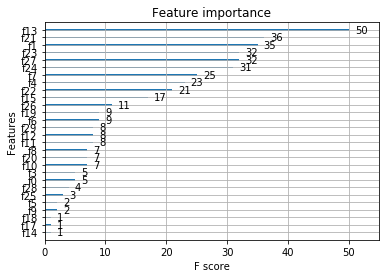

In [12]:
xgboost.plot_importance(pipeline.steps[1][1])

We can now make predictions on test data and evaluate the model.

In [13]:
y_pred = pipeline.predict(X_test.values)

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [14]:
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 94.50%


We can tune our model now to achieve better accuracy by using grid search and cross validation.

XGBoost has an extensive catalog of hyperparameters which provides great flexibility to shape the algorithm’s desired behavior. Let’s have a look at the most important ones:
- learning_rate (default=0.1): Boosting learning rate (xgb’s “eta”)
- n_estimators (default=100): Number of boosted trees to fit
- max_depth (default=3): Maximum tree depth for base learners
- objective (default='binary:logistic'): Specify the learning task and the corresponding learning objective or a custom objective function to be used

In below cell, we create our XGBoost pipeline and set up the parameter space.

In [15]:
pipeline_gs = Pipeline([('scaler', StandardScaler()), ('classifier', XGBClassifier())])
parameters = {'classifier__learning_rate': [0.01, 0.03], 'classifier__n_estimators': [50, 200]}

We can search for the best parameters over the specified parameters with GridSearchCV. You can use estimator.get_params().keys() to see the available hyperparameters for search.

In [16]:
from sklearn.grid_search import GridSearchCV

clf = GridSearchCV(pipeline_gs, parameters)

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [17]:
clf.fit(X_train.values, y_train.values)

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/src/conda3_runtime/home/en

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'classifier__n_estimators': [50, 200], 'classifier__learning_rate': [0.01, 0.03]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

We can see the performance result of all parameter combinations including the best parameter combination based on the model performance from the grid search scores.

In [18]:
clf.grid_scores_

[mean: 0.93767, std: 0.01382, params: {'classifier__n_estimators': 50, 'classifier__learning_rate': 0.01},
 mean: 0.93225, std: 0.01382, params: {'classifier__n_estimators': 200, 'classifier__learning_rate': 0.01},
 mean: 0.92954, std: 0.01014, params: {'classifier__n_estimators': 50, 'classifier__learning_rate': 0.03},
 mean: 0.94309, std: 0.01150, params: {'classifier__n_estimators': 200, 'classifier__learning_rate': 0.03}]

Best score and parameter set

In [19]:
print("Best score: %s" % (clf.best_score_))
print("Best parameter set: %s" % (clf.best_params_))

Best score: 0.943089430894309
Best parameter set: {'classifier__n_estimators': 200, 'classifier__learning_rate': 0.03}


We can see the accuracy of the best parameter combination on test set.

In [20]:
y_pred = clf.predict(X_test.values)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 95.50%


/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [21]:
y_pred = clf.predict([X_test.values[55]])
print(y_pred)

[0]


/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Let's see how we can save our XGBoost pipeline using the Watson Machine Learning instance and deploy it for online scoring.

<a id="persistence"></a>
## 4. Persist model

In this section you will learn how to use Python client libraries to store your XGBoost model in the Watson Machine Learning repository.

First, you must import the client libraries.

**Note**: Apache® Spark 2.1 or higher is required.

In [22]:
from repository.mlrepository import MetaNames
from repository.mlrepository import MetaProps
from repository.mlrepositoryclient import MLRepositoryClient
from repository.mlrepositoryartifact import MLRepositoryArtifact

Authenticate to Watson Machine Learning service on IBM Cloud.

**Action**: Enter authentication information from your Watson Machine Learning service instance here.</div>

In [23]:
# Enter your credentials here
wml_credentials = {
  "url": "https://ibm-watson-ml.mybluemix.net",
  "access_key": "***",
  "username": "***",
  "password": "***",
  "instance_id": "***"
}

In [24]:
service_path = wml_credentials["url"]
username = wml_credentials["username"]
password = wml_credentials["password"]
instance_id = wml_credentials["instance_id"]

**Tip**: service_path, user and password can be found on **Service Credentials** tab of service instance created in IBM Cloud. If you cannot see **instance_id** field in **Serice Credentials** generate new credentials by pressing **New credential (+)** button. 

In [25]:
ml_repository_client = MLRepositoryClient(service_path)
ml_repository_client.authorize(username, password)

### 4.1: Save a XGBoost model in the ML Repository

In this subsection you will learn how to save model artifact to your Watson Machine Learning instance.

Create an artifact and save to ML Repository

In this subsection you will learn how to save model artifact to your Watson Machine Learning instance.

Create an artifact and save to ML Repository

In [26]:
# Check if props is mandatory
# AUTHOR_NAME and AUTHOR_EMAIL have been removed for Watson Studio sharing
props1 = MetaProps({MetaNames.AUTHOR_NAME:"***", MetaNames.AUTHOR_EMAIL:"***"})

model_artifact = MLRepositoryArtifact(clf, name='Tumor_Type_Detection_v1_pipe', meta_props=props1)

saved_model = ml_repository_client.models.save(model_artifact)

Get saved model metadata from Watson Machine Learning.

In [27]:
dict_meta = saved_model.meta.get()
pprint.pprint(dict_meta)

{'authorEmail': 'umit.cakmak@pl.ibm.com',
 'authorName': 'Umit',
 'creationTime': datetime.datetime(2018, 3, 18, 23, 37, 40, 678000, tzinfo=tzutc()),
 'lastUpdated': datetime.datetime(2018, 3, 18, 23, 37, 40, 850000, tzinfo=tzutc()),
 'modelType': 'scikit-model-0.19',
 'modelVersionHref': 'https://ibm-watson-ml.mybluemix.net/v2/artifacts/models/4b7c9d27-6ca3-4b89-b726-9dd32ccb3958/versions/2d5908e6-513a-42a1-b227-f306dcdfb8ce',
 'pipelineVersionHref': None,
 'runtime': 'python-3.5',
 'trainingDataRef': {},
 'version': '2d5908e6-513a-42a1-b227-f306dcdfb8ce'}


# 5. Deploy and score in a Cloud

In this section you will learn how to create online scoring and to score a new data record by using the Watson Machine Learning REST API. 
For more information about REST APIs, see the [Swagger Documentation](http://watson-ml-api.mybluemix.net/).


To work with the Watson Machine Leraning REST API you must generate an access token. To do that you can use the following sample code:

In [28]:
import urllib3, requests, json

headers = urllib3.util.make_headers(basic_auth='{}:{}'.format(username, password))
url = '{}/v3/identity/token'.format(service_path)
response = requests.get(url, headers=headers)
mltoken = json.loads(response.text).get('token')
header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken}

### 5.1: Create online scoring endpoint

Now you can create an online scoring endpoint.

Get published_models url from instance details

In [29]:
#endpoint_instance = service_path + "/v3/wml_instances/" + instance_id
endpoint_instance = service_path + "/v3/wml_instances/" + instance_id
header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken} 

response_get_instance = requests.get(endpoint_instance, headers=header)
print(response_get_instance)
print(response_get_instance.text)

<Response [200]>
{"metadata":{"guid":"37c88e6f-2a51-43f8-be5a-17a928580075","url":"https://ibm-watson-ml.mybluemix.net/v3/wml_instances/37c88e6f-2a51-43f8-be5a-17a928580075","created_at":"2018-01-04T14:17:28.939Z","modified_at":"2018-03-18T23:37:41.004Z"},"entity":{"source":"Bluemix","published_models":{"url":"https://ibm-watson-ml.mybluemix.net/v3/wml_instances/37c88e6f-2a51-43f8-be5a-17a928580075/published_models"},"usage":{"expiration_date":"2018-04-01T00:00:00.000Z","computation_time":{"limit":180000,"current":0},"model_count":{"limit":200,"current":125},"prediction_count":{"limit":5000,"current":0},"gpu_count":{"limit":8,"current":0},"capacity_units":{"limit":180000000,"current":0},"deployment_count":{"limit":5,"current":1}},"plan_id":"3f6acf43-ede8-413a-ac69-f8af3bb0cbfe","status":"Active","organization_guid":"b0e61605-a82e-4f03-9e9f-2767973c084d","region":"us-south","account":{"id":"f52968f3dbbe7b0b53e15743d45e5e90","name":"Umit Cakmak's Account","type":"TRIAL"},"owner":{"ibm_id

In [30]:
endpoint_published_models = json.loads(response_get_instance.text).get('entity').get('published_models').get('url')
print(endpoint_published_models)

https://ibm-watson-ml.mybluemix.net/v3/wml_instances/37c88e6f-2a51-43f8-be5a-17a928580075/published_models


Execute the following sample code that uses the published_models endpoint to get deployments url.

Get the list of published models

In [31]:
header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken}

response_get = requests.get(endpoint_published_models, headers=header)
print(response_get)
print(response_get.text)

<Response [200]>
{"limit":1000,"resources":[{"metadata":{"guid":"6b76f1d7-aff2-445d-b816-0c4c573fbf7d","url":"https://ibm-watson-ml.mybluemix.net/v3/wml_instances/37c88e6f-2a51-43f8-be5a-17a928580075/published_models/6b76f1d7-aff2-445d-b816-0c4c573fbf7d","created_at":"2018-02-18T19:51:57.776Z","modified_at":"2018-02-18T19:52:24.785Z"},"entity":{"runtime_environment":"spark-2.0","learning_configuration_url":"https://ibm-watson-ml.mybluemix.net/v3/wml_instances/37c88e6f-2a51-43f8-be5a-17a928580075/published_models/6b76f1d7-aff2-445d-b816-0c4c573fbf7d/learning_configuration","author":{"name":"IBM","email":""},"name":"Product Line Prediction","description":"Predicts clients' interests in terms of sport product lines for chain stores in Europe.","label_col":"PRODUCT_LINE","learning_iterations_url":"https://ibm-watson-ml.mybluemix.net/v3/wml_instances/37c88e6f-2a51-43f8-be5a-17a928580075/published_models/6b76f1d7-aff2-445d-b816-0c4c573fbf7d/learning_iterations","training_data_schema":{"type"

Get published model deployment url

In [32]:
[endpoint_deployments] = [x.get('entity').get('deployments').get('url') for x in json.loads(response_get.text).get('resources') if x.get('metadata').get('guid') == saved_model.uid]

print(endpoint_deployments)

https://ibm-watson-ml.mybluemix.net/v3/wml_instances/37c88e6f-2a51-43f8-be5a-17a928580075/published_models/4b7c9d27-6ca3-4b89-b726-9dd32ccb3958/deployments


#### 5.1.2 Deploy Model

Create online deployment for published model

In [33]:
payload_online = {"name": "skl_xgb_cancer1_pipe", "description": "skl_xgb_Cancer", "type": "online"}
response_online = requests.post(endpoint_deployments, json=payload_online, headers=header)

print(response_online)
print(response_online.text)

<Response [201]>
{"metadata":{"guid":"65e272bc-ff7e-4136-b210-c7a1a831a7f8","url":"https://ibm-watson-ml.mybluemix.net/v3/wml_instances/37c88e6f-2a51-43f8-be5a-17a928580075/published_models/4b7c9d27-6ca3-4b89-b726-9dd32ccb3958/deployments/65e272bc-ff7e-4136-b210-c7a1a831a7f8","created_at":"2018-03-18T23:38:07.407Z","modified_at":"2018-03-18T23:38:11.463Z"},"entity":{"runtime_environment":"python-3.5","name":"skl_xgb_cancer1_pipe","scoring_url":"https://ibm-watson-ml.mybluemix.net/v3/wml_instances/37c88e6f-2a51-43f8-be5a-17a928580075/published_models/4b7c9d27-6ca3-4b89-b726-9dd32ccb3958/deployments/65e272bc-ff7e-4136-b210-c7a1a831a7f8/online","description":"skl_xgb_Cancer","published_model":{"author":{"name":"Umit","email":"umit.cakmak@pl.ibm.com"},"name":"Tumor_Type_Detection_v1_pipe","url":"https://ibm-watson-ml.mybluemix.net/v3/wml_instances/37c88e6f-2a51-43f8-be5a-17a928580075/published_models/4b7c9d27-6ca3-4b89-b726-9dd32ccb3958","guid":"4b7c9d27-6ca3-4b89-b726-9dd32ccb3958","creat

In [34]:
scoring_url = json.loads(response_online.text).get('entity').get('scoring_url')
print(scoring_url)

https://ibm-watson-ml.mybluemix.net/v3/wml_instances/37c88e6f-2a51-43f8-be5a-17a928580075/published_models/4b7c9d27-6ca3-4b89-b726-9dd32ccb3958/deployments/65e272bc-ff7e-4136-b210-c7a1a831a7f8/online


### 5. 3 Perform Prediction

Now, you can send (POST) new scoring records (new data) for which you would like to get predictions. To do that, execute the following sample code:

In [37]:
payload_scoring = {
   "values": [[0.16, 0.20, 0.010, 0.081, 11.69, 13.19, 14.78, 848.8, 19.48, 627.7, 43.75, 1.23, 3.27, 0.44, 6697.0, 208.3, 324.8, 139.2, 153.6, 2789.0, 0.2, 0.30, 0.013, 0.001, 15.90, 29.47, 35.97, 15.83, 31.03, 0.08]]        
}

response_scoring = requests.post(scoring_url, json=payload_scoring, headers=header)
pprint.pprint(response_scoring.text)

('{"fields": ["prediction", "probability"], "values": [[0, '
 '[0.8568325638771057, 0.1431674212217331]]]}\n')


As we can see, given patient record is classified as benign.

<a id="summary"></a>
## 6. Summary and next steps     

You successfully completed this notebook! You learned how to use XGBoost machine learning as well as Watson Machine Learning for model creation and deployment. Check out our _[Online Documentation](https://console.ng.bluemix.net/docs/services/PredictiveModeling/pm_service_api_spark.html)_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Data citations

Lichman, M. (2013). [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml). Irvine, CA: University of California, School of Information and Computer Science.

### Author

**Umit Mert Cakmak** is Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable insights.

Copyright © 2017, 2018 IBM. This notebook and its source code are released under the terms of the MIT License